# QPE

This program simulates a quantum circuit for binary addition using the quantum Fourier transform using Qiskit. \
Author: Michal Forgó \
Time: 02.14.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

Most likely bitstring: 001 → estimated φ = 0.125
{'001': 100000}


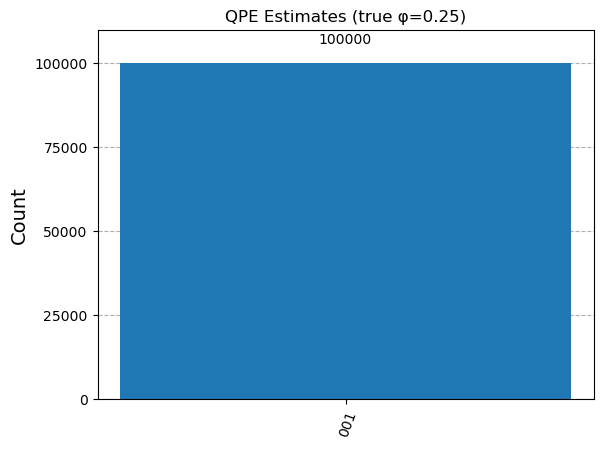

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# 1) Define target phase and unitary U = RZ(2πφ)
phi = 0.5
unitary_qc = QuantumCircuit(1, name="U")
unitary_qc.rz(2 * np.pi * phi, 0)
U_gate = unitary_qc.to_gate()  # now a Gate, has .power()

# 2) Build QPE circuit manually
n_count = 3
qc = QuantumCircuit(n_count + 1, n_count)

# 2.1 Prepare counting qubits in |+>
qc.h(range(n_count))

# 2.2 Prepare target qubit in |1> (an eigenstate of RZ)
qc.x(n_count)

# 2.3 Apply controlled-U^(2^j)
for j in range(n_count):
    # create controlled version of U_gate^2^j
    powered = U_gate.power(2**j)
    c_pow = powered.control(1)
    qc.append(c_pow, [j, n_count])

# 2.4 Inverse QFT on counting register
qc.append(QFT(n_count, inverse=True, name="QFT†"), range(n_count))

# 2.5 Measure counting register
qc.measure(range(n_count), range(n_count))

# 3) Simulate on AerSimulator
simulator = AerSimulator(shots=100_000)
compiled = transpile(qc, simulator)
job = simulator.run(compiled)
result = job.result()

# 4) Extract and display results
counts = result.get_counts(compiled)
most_likely = max(counts, key=counts.get)
estimated_phi = int(most_likely, 2) / 2**n_count

print(f"Most likely bitstring: {most_likely} → estimated φ = {estimated_phi:.3f}")
print(counts)
plot_histogram(counts, title=f"QPE Estimates (true φ={phi})")
